Tumor number t_no is 0-indexed; embo number e_no is 1-indexed. Should be fixed if there is time.

In [44]:
import pandas as pd
import numpy as np

In [45]:
fname = "marley's mets.xlsx"
writer = pd.ExcelWriter('output.xlsx')

In [46]:
def init_list_of_lists(dim1=11, dim2=3):
    lol = []
    for i in range(dim1):
        lol.append([0]*dim2)
    return lol

### Baseline

In [4]:
df = pd.read_excel(fname, sheetname="Segs_Baseline", index_col=1)
df = df[df["QEASL"] == 1]
included_mrns = list(df.index)

bl_cols = [0]*3
bl_df = [0]*3
for t_no in range(1,4):
    bl_cols[t_no-1] = [x for x in list(df.columns) if '_T'+str(t_no) in x]

bl_df[0] = df.dropna(axis=0, subset=[bl_cols[0][1]])
bl_df[1] = df.dropna(axis=0, subset=[bl_cols[1][1]])
bl_df[2] = df.dropna(axis=0, subset=[bl_cols[2][1]])

### Follow-up

In [17]:
fu1_cols = init_list_of_lists()
fu2_cols = init_list_of_lists()
fu1_df = init_list_of_lists()
fu2_df = init_list_of_lists()

for e_no in range(1,11):
    df = pd.read_excel(fname, sheetname="Segs_PostEmbo"+str(e_no))
    
    df = df[df["EPR_MRN"].isin(included_mrns)]
    df.set_index("EPR_MRN", inplace=True)
    
    for t_no in range(1,4):
        fu1_cols[e_no][t_no-1] = [x for x in list(df.columns) if str(e_no)+'1_T'+str(t_no) in x]
        fu2_cols[e_no][t_no-1] = [x for x in list(df.columns) if str(e_no)+'2_T'+str(t_no) in x]

    fu1_df[e_no][0] = df.dropna(axis=0, subset=[fu1_cols[e_no][0][1]])
    fu1_df[e_no][1] = df.dropna(axis=0, subset=[fu1_cols[e_no][1][1]])
    fu1_df[e_no][2] = df.dropna(axis=0, subset=[fu1_cols[e_no][2][1]])
    fu2_df[e_no][0] = df.dropna(axis=0, subset=[fu2_cols[e_no][0][1]])
    fu2_df[e_no][1] = df.dropna(axis=0, subset=[fu2_cols[e_no][1][1]])
    fu2_df[e_no][2] = df.dropna(axis=0, subset=[fu2_cols[e_no][2][1]])

### Clinical Data

In [18]:
clin_cols = ['EPR_MRN',
 'DOB',
 'Ethnicity',
 'Gender',
 'DateOfDeath',
 'Known_Alive_Date',
 'AgeAt1stEmbo',
 'TargetLesion_Pre_Post_Available',
 'Number_of_TACE',
 'Survival_or_Censor_Time_1stEmbo',
 'Survival(baseline-death)',
 '30DaySurvival',
 'TACEGroup',
 'SurvivalGroup(1=dead)',
 'LastEmbo',
 'Type',
 'Bilirubin',
 'Albumin',
 'INR',
 'Ascites',
 'Encephalopathy',
 'PS',
 'Portal_Invasion',
 'IntrahepaticVI',
 'ExtrahepaticVI',
 'NumberLesions',
 'TumorSize',
 'TumorDiffusion',
 'DistantMetastasis',
 'LymphNodeMetastasis',
 'HepB',
 'HepC',
 'HepD',
 'HIV',
 'Alcohol',
 'NASH',
 'Crypto',
 'Cirrhosis',
 'AFP',
 'LAB_BASELINE_DIAGNOSTIC_LAST_MODIFIED',
 'LAB_BASELINE_DIAGNOSTIC_MODIFIED_BY',
 'transplant',
 'transplantdate',
 'resection',
 'resectiondate',
 'sorafenib',
 'labdate',
 'mrdate']

In [19]:
clin_df = pd.read_excel(fname, sheetname="Data")
clin_df.drop(set(clin_df.columns) - set(clin_cols), axis=1, inplace=True)
clin_df.dropna(axis=0, subset=["EPR_MRN"], inplace=True)

In [20]:
clin_df["EPR_MRN"] = clin_df["EPR_MRN"].apply(int)
clin_df.set_index("EPR_MRN", inplace=True)
clin_df = clin_df.loc[included_mrns]

### Transformation

In [21]:
target_cols = ['MRN', 'Embo Num for Tumor', 'Embo Num for Patient', 'Tumor Number',
              'Embo Date', 'Embo Type',
              'Pre-Image Date', 'Pre-Image Type',
              'Pre-Location', 'Pre-RECIST', 'Pre-mRECIST',
              'Pre-Tumor Vol', 'Pre-Enhanced Vol', 'Pre-% Enhancement',
              'Post-Image Date', 'Post-Image Type',
              'Post-Location', 'Post-RECIST', 'Post-mRECIST',
              'Post-Tumor Vol', 'Post-Enhanced Vol', 'Post-% Enhancement']

embos = pd.DataFrame(columns=target_cols)

In [22]:
bl_date = "Baseline 1 Date"
bl_type = "Baseline 1 Type"
e_no = 1

for t_no in range(3):
    for mrn in list(bl_df[t_no].index):
        row = bl_df[t_no].loc[mrn]
        embo_date = row["EMBO " + str(e_no) + " Date"]
        embo_type = row["EMBO " + str(e_no) + " Type"]
        pre_img_date = row["Baseline 1 Date"]
        pre_img_type = row["Baseline 1 Type"]
        pre_data = list(row[bl_cols[t_no]])
        
        try:
            row = fu1_df[1][t_no].loc[mrn]
            post_img_date = row["Follow-Up " + str(e_no) + "-1 Date"]
            post_img_type = row["Follow-Up " + str(e_no) + "-1 Type"]
            post_data = list(row[fu1_cols[1][t_no]])
        except KeyError:
            try:
                row = fu2_df[1][t_no].loc[mrn]
                post_img_date = row["Follow-Up " + str(e_no) + "-2 Date"]
                post_img_type = row["Follow-Up " + str(e_no) + "-2 Type"]
                post_data = list(row[fu2_cols[1][t_no]])
            except KeyError as e:
                print("Cannot find F/U imaging for BL T%d: %s" % (t_no+1, str(e)))
                continue
        
        #try:
        #    e_no_tumor = 1 + max(embos[(embos['MRN'] == mrn) & (embos['Tumor Number'] == t_no+1)]['Embo Num for Tumor'])
        #except ValueError:
        #    e_no_tumor = 1

        embos = embos.append(pd.DataFrame([[mrn, np.nan, e_no, t_no+1, embo_date, embo_type,
                      pre_img_date, pre_img_type] + pre_data +
                      [post_img_date, post_img_type] + post_data], columns=target_cols))

In [23]:
for e_no in range(2,10):
    for t_no in range(3):
        for mrn in set(fu1_df[e_no-1][t_no].index).union(set(fu2_df[e_no-1][t_no].index)):
            try:
                row = fu2_df[e_no-1][t_no].loc[mrn]
                pre_img_date = row["Follow-Up " + str(e_no-1) + "-2 Date"]
                pre_img_type = row["Follow-Up " + str(e_no-1) + "-2 Type"]
                pre_data = list(row[fu2_cols[e_no-1][t_no]])
            except KeyError:
                row = fu1_df[e_no-1][t_no].loc[mrn]
                pre_img_date = row["Follow-Up " + str(e_no-1) + "-1 Date"]
                pre_img_type = row["Follow-Up " + str(e_no-1) + "-1 Type"]
                pre_data = list(row[fu1_cols[e_no-1][t_no]])
                
            embo_date = row["EMBO " + str(e_no) + " Date"]
            embo_type = row["EMBO " + str(e_no) + " Type"]
                
            try:
                post_img_date = fu1_df[e_no][t_no].loc[mrn]["Follow-Up " + str(e_no) + "-1 Date"]
                post_img_type = fu1_df[e_no][t_no].loc[mrn]["Follow-Up " + str(e_no) + "-1 Type"]
                post_data = list(fu1_df[e_no][t_no].loc[mrn][fu1_cols[e_no][t_no]])
            except KeyError:
                try:
                    post_img_date = fu2_df[e_no][t_no].loc[mrn]["Follow-Up " + str(e_no) + "-2 Date"]
                    post_img_type = fu2_df[e_no][t_no].loc[mrn]["Follow-Up " + str(e_no) + "-2 Type"]
                    post_data = list(fu2_df[e_no][t_no].loc[mrn][fu2_cols[e_no][t_no]])
                except KeyError as e:
                    continue

            #try:
            #    e_no_tumor = 1 + max(embos[(embos['MRN'] == mrn) & (embos['Tumor Number'] == t_no+1)]['Embo Num for Tumor'])
            #except ValueError:
            #    e_no_tumor = 1

            embos = embos.append(pd.DataFrame([[mrn, np.nan, e_no, t_no+1, embo_date, embo_type,
                          pre_img_date, pre_img_type] + pre_data +
                          [post_img_date, post_img_type] + post_data],
                          columns=target_cols))

Mark as questionable if this tumor has already been embolized, and another tumor was embolized in the same operation.

In [24]:
def interrogate(row):
    """Mark embo rows that might not be true embos.
    This includes embos that meet the following criteria:
    - At least one other tumor was embolized in the same operation
    - This is not the first or last embo for this tumor
    """
    mrn_subset = embos[embos["MRN"] == row["MRN"]]
    max_embo = max(mrn_subset[mrn_subset["Tumor Number"] == row["Tumor Number"]]["Embo Num for Patient"])
    
    return len(mrn_subset[mrn_subset["Embo Num for Patient"] == row["Embo Num for Patient"]]) > 1 and \
           1 < row["Embo Num for Tumor"] < max_embo
    
embos["Questionable"] = embos.apply(lambda row: interrogate(row), axis=1)

Renumber the tumor embos after filtering the questionable column

In [25]:
def renumber(row):
    if row["Questionable"]:
        return np.nan
    
    ls = list(embos[(embos["Questionable"] == False) & (embos["MRN"] == row["MRN"]) &
             (embos["Tumor Number"] == row["Tumor Number"])]["Embo Num for Patient"])
    
    return sorted(ls).index(row["Embo Num for Patient"]) + 1


embos["Embo Num for Tumor"] = embos.apply(lambda row: renumber(row), axis=1)

In [26]:
criteria = ["RECIST", "mRECIST", "Tumor Vol", "Enhanced Vol"]
pr_cutoffs = {"RECIST": 0.7, "mRECIST": 0.7, "Tumor Vol": 0.35, "Enhanced Vol": 0.35}
pd_cutoffs = {"RECIST": 1.2, "mRECIST": 1.2, "Tumor Vol": 1.73, "Enhanced Vol": 1.73}
cr_cutoffs = {"RECIST": 0.1, "mRECIST": 0.1, "Tumor Vol": 0.05, "Enhanced Vol": 0.05}

def assess_response(row, category):
    if row["Post-"+category] <= cr_cutoffs[category] * row["Pre-"+category]:
        return "CR"
    elif row["Post-"+category] <= pr_cutoffs[category] * row["Pre-"+category]:
        return "PR"
    elif row["Post-"+category] >= pd_cutoffs[category] * row["Pre-"+category]:
        return "PD"
    else:
        return "SD"

for category in criteria:
    embos = embos[embos["Pre-"+category].apply(lambda x: type(x) == float)]
    embos = embos[embos["Post-"+category].apply(lambda x: type(x) == float)]
    embos["Response: "+category] = embos.apply(lambda row: assess_response(row, category), axis=1)

In [27]:
embos.to_excel(writer, sheet_name='Embos', index=False)

## Patient-level analysis

In [28]:
embos = embos[embos["Questionable"] == False]

In [29]:
target_cols = ['MRN', 'Total Embos', 'Total Tumors'] + \
               ['Total Pre-'+category for category in criteria] + \
               ['Total Post-'+category for category in criteria] + \
               ['Responder: '+category for category in criteria]

patients = pd.DataFrame(columns=target_cols)

In [30]:
for mrn in set(embos["MRN"]):
    subset = embos[embos["MRN"] == mrn]
    tot_e = max(subset["Embo Num for Patient"])
    tot_t = max(subset["Tumor Number"])

    for category in criteria:
        embos = embos[embos["Pre-"+category].apply(lambda x: type(x) == float)]
        embos = embos[embos["Post-"+category].apply(lambda x: type(x) == float)]
        embos["Response: "+category] = embos.apply(lambda row: assess_response(row, category), axis=1)
    
    tot_pre_value = {}
    for category in criteria:
        tot_pre_value[category] = sum(subset[subset["Embo Num for Tumor"] == 1]["Pre-"+category])
        
    tot_post_value = dict(zip(criteria, [0,0,0,0]))
    responder = dict(zip(criteria, [True, True, True, True]))
    for t_no in range(tot_t):
        t_subset = subset[subset["Tumor Number"] == t_no+1]
        
        if len(t_subset) == 0: # some t_nos are missing because they had non-numeric entries and were excluded
            continue
            
        max_embo = max(t_subset["Embo Num for Tumor"])

        for category in criteria:
            tot_post_value[category] += sum(t_subset[t_subset["Embo Num for Tumor"] == max_embo]["Post-"+category])
            
            try:
                if len(t_subset[(t_subset["Embo Num for Tumor"] == max_embo) &
                                (t_subset["Response: "+category] == "PD")]) > 0:
                    responder[category] = False # non-responder if any of the final embos on a tumor were "unsuccessful"
            except:
                responder[category] = np.nan
        
    new_row = pd.DataFrame([[mrn, tot_e, tot_t] +
                            [tot_pre_value[category] for category in criteria] +
                            [tot_post_value[category] for category in criteria] +
                            [responder[category] for category in criteria]],
                            columns=target_cols)
    
    patients = patients.append(new_row)

In [31]:
patients.set_index("MRN", inplace=True)

In [32]:
patients = pd.concat([patients, clin_df], axis=1)

## Scenario analysis

In [33]:
target_cols = ['MRN', 'Tumor Number', 'Number of Embos'] + \
              ['Initial Pre-'+category for category in criteria] + \
              ['Final Post-'+category for category in criteria] + \
              ['Days btwn embo %d and %d' % (x, x+1) for x in range(1,7)] + \
              ['Days btwn embo %d post image and embo %d pre image' % (x, x+1) for x in range(1,7)] + \
              ['Progression (enhanced vol) btwn embo %d post image and embo %d pre image' % (x, x+1) for x in range(1,7)]

tumors = pd.DataFrame(columns=target_cols)

In [34]:
def get_diffs(t_subset, e_no, embo_diff):
    dt_embo = (t_subset[t_subset["Embo Num for Tumor"] == e_no + embo_diff]["Embo Date"] -
                       t_subset[t_subset["Embo Num for Tumor"] == e_no]["Embo Date"])[0].days

    dt_img = (t_subset[t_subset["Embo Num for Tumor"] == e_no + embo_diff]["Pre-Image Date"] -
                      t_subset[t_subset["Embo Num for Tumor"] == e_no]["Post-Image Date"])[0].days

    if dt_img != 0:
        tumor_change = (t_subset[t_subset["Embo Num for Tumor"] == e_no + embo_diff]["Pre-Enhanced Vol"] / \
                                t_subset[t_subset["Embo Num for Tumor"] == e_no]["Post-Enhanced Vol"])[0]
        if tumor_change == 0:
            tumor_change = "Missing"
    else:
        tumor_change = np.nan
        
    return dt_embo, dt_img, tumor_change

In [35]:
for mrn in set(embos["MRN"]):
    mrn_subset = embos[embos["MRN"] == mrn]
    tot_t = max(mrn_subset["Tumor Number"])
    
    for t_no in range(tot_t):
        t_subset = mrn_subset[mrn_subset["Tumor Number"] == t_no]
        
        if len(t_subset) == 0:
            continue
            
        max_embo = max(t_subset["Embo Num for Tumor"])

        init_pre_value = dict(zip(criteria, [np.nan]*4))
        last_post_value = dict(zip(criteria, [np.nan]*4))
        for category in criteria:
            try:
                init_pre_value[category] = t_subset[t_subset["Embo Num for Tumor"] == 1]["Pre-"+category][0]
            except: #missing data
                continue
            last_post_value[category] = t_subset[t_subset["Embo Num for Tumor"] == max_embo]["Post-"+category][0]
        
        dt_embo = [np.nan]*7
        dt_img = [np.nan]*7
        tumor_change = [np.nan]*7
        for e_no in range(1,max_embo):
            dt_embo[e_no-1], dt_img[e_no-1], tumor_change[e_no-1] = get_diffs(t_subset, e_no, 1)
        
        new_row = pd.DataFrame([[mrn, t_no, max_embo] +
                                [init_pre_value[category] for category in criteria] +
                                [last_post_value[category] for category in criteria] +
                                [dt_embo[x] for x in range(6)] +
                                [dt_img[x] for x in range(6)] +
                                [tumor_change[x] for x in range(6)]],
                                columns=target_cols)

        tumors = tumors.append(new_row)

In [36]:
tumors.to_excel(writer, sheet_name='Tumors', index=False)

In [37]:
def categorize_intent(row, embos, time_cutoff=90):  
    if row["Total Tumors"] == 1:
        return "Single lesion planned"

    elif row["Total Tumors"] == 2:
        mrn_subset = embos[embos["MRN"] == row["MRN"]]

        min_embo = min(mrn_subset["Embo Num for Patient"])
        first_t_no = mrn_subset[mrn_subset["Embo Num for Patient"] == min_embo]["Tumor Number"]

        if len(first_t_no) > 1:
            return "Multiple lesions planned simultaneously"
        first_t_no = first_t_no[0]

        t1_subset = mrn_subset[mrn_subset["Tumor Number"] == first_t_no]
        t2_subset = mrn_subset[mrn_subset["Tumor Number"] == (2 if first_t_no == 1 else 1)]

        first_embo_for_t2 = t2_subset[t2_subset["Embo Num for Tumor"] == 1]
        date_of_t2_embo = first_embo_for_t2["Embo Date"]

        prev_embo_for_t1 = t1_subset[t1_subset["Embo Num for Patient"] == \
                            first_embo_for_t2["Embo Num for Patient"][0] - 1]
        date_of_t1_embo = prev_embo_for_t1["Embo Date"]

        if (date_of_t2_embo - date_of_t1_embo)[0].days > time_cutoff:
            return "Multiple lesions unplanned"
        else:
            return "Multiple lesions planned sequentially"

    else:
        return "3 lesions"

In [38]:
patients.reset_index(inplace=True)

In [39]:
patients.rename(columns = {'index':'MRN'}, inplace = True)

In [40]:
patients['Category'] = patients.apply(lambda row: categorize_intent(row, embos), axis=1)

In [41]:
patients.to_excel(writer, sheet_name='Patients', index=False)

In [43]:
writer.save()

In [37]:
import matplotlib.pyplot as plt

In [52]:
%matplotlib inline

In [47]:
dt = []
for x in range(1,7):
    dt.append(tumors['Days btwn embo %d and %d' % (x, x+1)].dropna().values)
dt = [x for ls in dt for x in ls]

(array([ 52.,  15.,   5.,   6.,   3.,   0.,   1.,   0.,   2.,   0.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([   28.  ,    69.66,   111.32,   152.98,   194.64,   236.3 ,
          277.96,   319.62,   361.28,   402.94,   444.6 ,   486.26,
          527.92,   569.58,   611.24,   652.9 ,   694.56,   736.22,
          777.88,   819.54,   861.2 ,   902.86,   944.52,   986.18,
         1027.84,  1069.5 ,  1111.16,  1152.82,  1194.48,  1236.14,
         1277.8 ,  1319.46,  1361.12,  1402.78,  1444.44,  1486.1 ,
         1527.76,  1569.42,  1611.08,  1652.74,  1694.4 ,  1736.06,
         1777.72,  1819.38,  1861.04,  1902.7 ,  1944.36,  1986.02,
         2027.68,  2069.34,  2111.  ]),
 <a list of 50 Patch objects>)

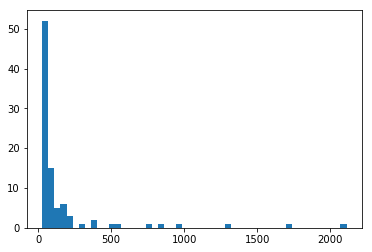

In [55]:
plt.hist(dt, bins=50)